# Simulación de Plantas CSP y Análisis de Sensibilidad

Este notebook presenta una simulación termoeléctrica utilizando el modelo de torre central con almacenamiento en sales fundidas (CSP) mediante PySAM. Se evalúa el desempeño técnico y económico en distintos países, además de realizar un análisis de sensibilidad para parámetros clave como el múltiplo solar y las horas de almacenamiento térmico.


In [2]:
import PySAM.TcsmoltenSalt as TCSMS
import PySAM.Lcoefcr as Lcoefcr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

## Definición de Funciones

En esta sección se definen las funciones necesarias para:
- Configurar el entorno de simulación (rutas, países y parámetros).
- Cargar archivos de datos climáticos.
- Ejecutar simulaciones CSP para diferentes ubicaciones.
- Realizar análisis de sensibilidad técnica y económica.


In [3]:
def configurar_entorno():
    """Define las rutas base, lista de países y crea directorios de salida."""
    # Rutas base - AJUSTA ESTAS RUTAS A TU ENTORNO
    # Intenta usar rutas relativas si es posible

    # Ejemplo de rutas relativas (preferible si la estructura es consistente)
    # datos_base_dir = os.path.join(base_repo_dir, "PRUEBA1", "Datos")
    # output_dir_results = os.path.join(base_repo_dir, "PRUEBA1", "Resultados")
    # output_dir_graphs = os.path.join(base_repo_dir, "PRUEBA1", "graficos")

    # Rutas absolutas (si las relativas no funcionan o prefieres explícitas)
    # Asegúrate que estas rutas existan o sean creadas correctamente
    datos_base_dir = "/home/nicole/UA/NicoleTorres/PRUEBA1/Datos" # Ajustado a la estructura clonada
    output_dir_results = "/home/nicole/UA/NicoleTorres/PRUEBA1/Resultados" # Ajustado
    output_dir_graphs = "/home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_csp" # Ajustado

    #datos_base_dir = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos" # Ajustado a la estructura clonada
    #output_dir_results = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados" # Ajustado
    #output_dir_graphs = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp"

    # Países a simular (Asegúrate que los archivos CSV existen)
    paises = [
        {"nombre": "Australia", "archivo_sufijo": "australia", "color": "blue"},
        {"nombre": "Chile", "archivo_sufijo": "chile", "color": "red"},
        {"nombre": "Espana", "archivo_sufijo": "espana", "color": "green"}
    ]

    # Crear directorios de salida si no existen
    if not os.path.exists(output_dir_results):
        os.makedirs(output_dir_results)
    if not os.path.exists(output_dir_graphs):
        os.makedirs(output_dir_graphs)

    # Parámetros fijos (se podrían mover a un archivo de config si crecen)
    config_params = {
        "fixed_charge_rate": 0.08,
        "fixed_operating_cost": 1000000,
        "variable_operating_cost": 0.02,
        "tshours_sensitivity": 12, # Para sensibilidad FCR
        "tshours_solarm_sens": 12, # Para sensibilidad Múltiplo Solar
        "fcr_solarm_sens": 0.08, # Para sensibilidad Múltiplo Solar
    }


    print("Directorios creados/verificados:")
    print(f"  Datos: {datos_base_dir}")
    print(f"  Resultados: {output_dir_results}")
    print(f"  Gráficos: {output_dir_graphs}")


    return {
        "datos_base_dir": datos_base_dir,
        "output_dir_results": output_dir_results,
        "output_dir_graphs": output_dir_graphs,
        "paises": paises,
        "params": config_params
    }

In [15]:
def cargar_recurso_solar(pais_nombre, archivo_solar):
    """Carga los datos del recurso solar desde archivo CSV, con manejo especial para Australia."""
    resource_input = {}
    if pais_nombre == "Australia":
        
        print(f"  Leyendo archivo de {pais_nombre} manualmente con pandas...")
        try:
            # Leer metadatos
            meta_df = pd.read_csv(archivo_solar, nrows=1, header=None, skiprows=1)
            lat = meta_df.iloc[0, 5]
            lon = meta_df.iloc[0, 6]
            tz = meta_df.iloc[0, 9]
            elev = meta_df.iloc[0, 8]

            # Leer datos
            data_df = pd.read_csv(archivo_solar, skiprows=2)
            # <<< INICIO: Verificaciones agregadas >>> <--- EL BLOQUE DEBE ESTAR DESPUÉS DE LA LÍNEA ANTERIOR
            print(f"    --- Verificando datos de {pais_nombre} --- ")
            print("    Estadísticas Descriptivas:")
            # Selecciona solo columnas numéricas relevantes para describe()
            numeric_cols_to_describe = ['DNI', 'DHI', 'GHI', 'Temperature', 'Wind Speed', 'Dew Point', 'Pressure']
            cols_present = [col for col in numeric_cols_to_describe if col in data_df.columns]
            if cols_present:
                print(data_df[cols_present].describe())
            else:
                print("      No se encontraron columnas numéricas relevantes para describir.")

            print("\n    Conteo de valores negativos:")
            for col in ['DNI', 'DHI', 'GHI']:
                if col in data_df.columns:
                    count_neg = (data_df[col] < 0).sum()
                    print(f"      {col} < 0: {count_neg}")
                else:
                     print(f"      Columna {col} no encontrada.")

            print("\n    Tipos de datos (primeras columnas):")
            print(data_df.dtypes.head())
            print("    --- Fin Verificación --- ")
            # <<< FIN: Verificaciones agregadas >>>
            required_cols = {
                'Year': 'year', 'Month': 'month', 'Day': 'day',
                'Hour': 'hour', 'Minute': 'minute', 'DNI': 'dn',
                'DHI': 'df', 'GHI': 'gh', 'Temperature': 'tdry',
                'Wind Speed': 'wspd'
            }
            optional_cols = {'Dew Point': 'tdew', 'Pressure': 'pres'}

            resource_data = {'lat': lat, 'lon': lon, 'tz': tz, 'elev': elev, 'location': pais_nombre}
            cols_to_extract = {}

            for orig_col, sam_col in required_cols.items():
                if orig_col not in data_df.columns:
                    raise ValueError(f"Columna requerida '{orig_col}' no encontrada en {archivo_solar}")
                cols_to_extract[sam_col] = data_df[orig_col].tolist()

            for orig_col, sam_col in optional_cols.items():
                if orig_col in data_df.columns:
                    cols_to_extract[sam_col] = data_df[orig_col].tolist()
                else:
                    print(f"  Advertencia: Columna opcional '{orig_col}' no encontrada.")

            resource_data.update(cols_to_extract)
            resource_input = {"solar_resource_data": resource_data}
            print(f"  Datos de {pais_nombre} cargados manualmente. Lat:{lat}, Lon:{lon}, TZ:{tz}, Elev:{elev}")
            return resource_input

        except Exception as e:
            print(f"  ERROR al leer manualmente {archivo_solar}: {e}.")
            return None # Indicar fallo
    else:
        # Para otros países, usar el método original si el archivo existe
        if os.path.exists(archivo_solar):
             print(f"  Usando referencia de archivo para {pais_nombre}: {archivo_solar}")
             return {"solar_resource_file": archivo_solar}
        else:
            print(f"  ERROR: Archivo solar no encontrado para {pais_nombre}: {archivo_solar}")
            return None # Indicar fallo

In [5]:
def ejecutar_simulacion_principal(config):
    """Ejecuta la simulación principal variando las horas de almacenamiento."""
    print("-" * 50)
    print("--- Iniciando Simulación Principal (Variando Horas Almacenamiento por País) ---")
    print("-" * 50)

    storage_hours_range = list(range(4, 19))  # De 4 a 18 horas
    output_csv_filename = "resultados_simulacion_csp_multi.csv"
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Simulación Principal para: {pais_nombre}...")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
             print(f"  Saltando simulación principal para {pais_nombre} debido a error en recurso solar.")
             continue # Saltar al siguiente país

        for tshours in storage_hours_range:
            print(f"    Simulando con {tshours} horas de almacenamiento...")
            try:
                csp_model = TCSMS.default("MSPTSingleOwner")
                csp_model.SolarResource.assign(resource_input) # Usar el recurso cargado
                csp_model.SystemDesign.assign({"tshours": tshours})
                csp_model.execute()

                annual_energy = csp_model.Outputs.annual_energy
                total_installed_cost = csp_model.Outputs.total_installed_cost

                lcoe_model = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model.SimpleLCOE.assign({
                    "annual_energy": annual_energy,
                    "capital_cost": total_installed_cost,
                    "fixed_charge_rate": config["params"]["fixed_charge_rate"],
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model.execute()
                lcoe = lcoe_model.Outputs.lcoe_fcr
                print(f"      Energía: {annual_energy:.0f} kWh, Costo: ${total_installed_cost:,.0f}, LCOE: {lcoe:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Horas_almacenamiento': tshours,
                    'Generacion_energia_kWh': annual_energy,
                    'Costo_total_planta_$': total_installed_cost,
                    'LCOE_$/kWh': lcoe
                })

            except Exception as e:
                print(f"      ERROR al ejecutar la simulación ({tshours}h): {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Horas_almacenamiento': tshours,
                    'Generacion_energia_kWh': None, 'Costo_total_planta_$': None, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True) # Eliminar filas con errores
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados principales combinados guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados principales combinados: {e}")
            return pd.DataFrame() # Devolver DF vacío si falla el guardado
    else:
        print("No se generaron resultados válidos en la simulación principal.")
        return pd.DataFrame() # Devolver DF vacío si no hay resultados

    return df_results

In [6]:
def ejecutar_sensibilidad_fcr(config):
    """Ejecuta el análisis de sensibilidad variando el FCR."""
    print("-" * 50)
    print("--- Iniciando Análisis de Sensibilidad FCR (por País) ---")
    print("-" * 50)

    tshours_sensitivity = config["params"]["tshours_sensitivity"]
    fcr_sensitivity_range = np.arange(0.05, 0.101, 0.01)
    output_csv_filename = "resultados_sensibilidad_fcr_multi.csv"
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Sensibilidad FCR para: {pais_nombre} ({tshours_sensitivity}h almacenamiento)... ")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
            print(f"  Saltando sensibilidad FCR para {pais_nombre} debido a error en recurso solar.")
            continue

        # Simular una vez para obtener energía y costo base
        try:
            csp_model_base = TCSMS.default("MSPTSingleOwner")
            csp_model_base.SolarResource.assign(resource_input) # Usar recurso cargado
            csp_model_base.SystemDesign.assign({"tshours": tshours_sensitivity})
            csp_model_base.execute()
            base_annual_energy = csp_model_base.Outputs.annual_energy
            base_total_cost = csp_model_base.Outputs.total_installed_cost
            print(f"    Energía base ({tshours_sensitivity}h): {base_annual_energy:.0f} kWh, Costo base: ${base_total_cost:,.0f}")
        except Exception as e:
            print(f"    ERROR al obtener energía/costo base para sensibilidad FCR: {e}. Saltando FCR para este país.")
            continue

        for fcr in fcr_sensitivity_range:
            print(f"    Calculando LCOE con FCR = {fcr:.3f}...")
            try:
                lcoe_model_sens = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model_sens.SimpleLCOE.assign({
                    "annual_energy": base_annual_energy,
                    "capital_cost": base_total_cost,
                    "fixed_charge_rate": fcr,
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model_sens.execute()
                lcoe_sens = lcoe_model_sens.Outputs.lcoe_fcr
                print(f"      LCOE: {lcoe_sens:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Tasa_carga_fija': fcr,
                    'Generacion_energia_kWh': base_annual_energy,
                    'Costo_total_planta_$': base_total_cost,
                    'LCOE_$/kWh': lcoe_sens
                })
            except Exception as e:
                print(f"      ERROR al calcular LCOE para FCR={fcr:.3f}: {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Tasa_carga_fija': fcr,
                    'Generacion_energia_kWh': base_annual_energy, 'Costo_total_planta_$': base_total_cost, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True)
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados sensibilidad FCR combinados guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados sensibilidad FCR: {e}")
            return pd.DataFrame()
    else:
        print("No se generaron resultados válidos en el análisis de sensibilidad FCR.")
        return pd.DataFrame()

    return df_results

In [7]:
def ejecutar_sensibilidad_multiplo_solar(config):
    """Ejecuta el análisis de sensibilidad variando el Múltiplo Solar."""
    print("-" * 50)
    print("--- Iniciando Análisis de Sensibilidad Múltiplo Solar (por País) ---")
    print("-" * 50)

    tshours_solarm_sens = config["params"]["tshours_solarm_sens"]
    fcr_solarm_sens = config["params"]["fcr_solarm_sens"]
    solarm_sensitivity_range = np.arange(1.5, 3.01, 0.25)
    output_csv_filename = "resultados_sensibilidad_solarm_multi.csv"
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Sensibilidad Múltiplo Solar para: {pais_nombre} ({tshours_solarm_sens}h almacenamiento, FCR={fcr_solarm_sens})... ")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
            print(f"  Saltando sensibilidad Múltiplo Solar para {pais_nombre} debido a error en recurso solar.")
            continue

        for solarm in solarm_sensitivity_range:
            print(f"    Simulando con Múltiplo Solar = {solarm:.2f}...")
            try:
                csp_model_solarm = TCSMS.default("MSPTSingleOwner")
                csp_model_solarm.SolarResource.assign(resource_input) # Usar recurso cargado
                csp_model_solarm.SystemDesign.assign({"tshours": tshours_solarm_sens, "solarm": solarm})
                csp_model_solarm.execute()

                annual_energy_solarm = csp_model_solarm.Outputs.annual_energy
                total_installed_cost_solarm = csp_model_solarm.Outputs.total_installed_cost

                lcoe_model_solarm = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model_solarm.SimpleLCOE.assign({
                    "annual_energy": annual_energy_solarm,
                    "capital_cost": total_installed_cost_solarm,
                    "fixed_charge_rate": fcr_solarm_sens,
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model_solarm.execute()
                lcoe_solarm = lcoe_model_solarm.Outputs.lcoe_fcr
                print(f"      Energía: {annual_energy_solarm:.0f} kWh, Costo: ${total_installed_cost_solarm:,.0f}, LCOE: {lcoe_solarm:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Multiplo_Solar': solarm,
                    'Generacion_energia_kWh': annual_energy_solarm,
                    'Costo_total_planta_$': total_installed_cost_solarm,
                    'LCOE_$/kWh': lcoe_solarm
                })

            except Exception as e:
                print(f"      ERROR al ejecutar la simulación (Múltiplo Solar={solarm:.2f}): {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Multiplo_Solar': solarm,
                    'Generacion_energia_kWh': None, 'Costo_total_planta_$': None, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True)
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados sensibilidad Múltiplo Solar combinados guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados sensibilidad Múltiplo Solar: {e}")
            return pd.DataFrame()
    else:
        print("No se generaron resultados válidos en el análisis de sensibilidad de Múltiplo Solar.")
        return pd.DataFrame()

    return df_results

In [8]:
def generar_graficos_comparativos(config, df_main, df_fcr, df_solarm, nombre_grafico):
    """Genera UN gráfico comparativo 2D específico a partir de los DataFrames de resultados.

    Args:
        config (dict): Diccionario de configuración.
        df_main (pd.DataFrame): DataFrame de la simulación principal (variando horas).
        df_fcr (pd.DataFrame): DataFrame de la sensibilidad FCR.
        df_solarm (pd.DataFrame): DataFrame de la sensibilidad Múltiplo Solar.
        nombre_grafico (str): Nombre clave del gráfico a generar. Opciones:
            'lcoe_vs_horas', 'energia_vs_horas', 'costo_vs_horas',
            'sens_lcoe_fcr', 'sens_lcoe_solarm'.
    """
    print("-" * 50)
    print(f"--- Generando Gráfico Específico: {nombre_grafico} --- ")
    print("-" * 50)

    output_dir_graphs = config["output_dir_graphs"]
    palette = {pais["nombre"]: pais["color"] for pais in config["paises"]}
    tshours_sensitivity = config["params"]["tshours_sensitivity"]
    tshours_solarm_sens = config["params"]["tshours_solarm_sens"]
    fcr_solarm_sens = config["params"]["fcr_solarm_sens"]

    # Validar nombre_grafico
    graficos_validos = ['lcoe_vs_horas', 'energia_vs_horas', 'costo_vs_horas', 'sens_lcoe_fcr', 'sens_lcoe_solarm']
    if nombre_grafico not in graficos_validos:
        print(f"Error: Nombre de gráfico '{nombre_grafico}' no es válido. Opciones: {graficos_validos}")
        return

    # Generar gráfico específico
    plt.figure(figsize=(10, 6))
    graph_generated = False
    graph_path = ""

    try:
        if nombre_grafico == 'lcoe_vs_horas':
            if not df_main.empty:
                for pais, group in df_main.groupby('Pais'):
                    plt.plot(group['Horas_almacenamiento'], group['LCOE_$/kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
                plt.xlabel('Horas de Almacenamiento')
                plt.ylabel('LCOE ($/kWh)')
                plt.title('LCOE vs Horas de Almacenamiento por País (CSP)')
                plt.legend(title='País')
                plt.grid(True, linestyle='--')
                plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
                graph_path = os.path.join(output_dir_graphs, "comparativo_lcoe_vs_horas_csp.png")
                graph_generated = True
            else:
                print("Saltando gráfico 'lcoe_vs_horas' (sin datos principales).")

        elif nombre_grafico == 'energia_vs_horas':
            if not df_main.empty:
                for pais, group in df_main.groupby('Pais'):
                    plt.plot(group['Horas_almacenamiento'], group['Generacion_energia_kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
                plt.xlabel('Horas de Almacenamiento')
                plt.ylabel('Generación Anual (kWh)')
                plt.title('Generación Anual vs Horas de Almacenamiento por País (CSP)')
                plt.legend(title='País')
                plt.grid(True, linestyle='--')
                plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f')) # Formato sin decimales
                graph_path = os.path.join(output_dir_graphs, "comparativo_energia_vs_horas_csp.png")
                graph_generated = True
            else:
                print("Saltando gráfico 'energia_vs_horas' (sin datos principales).")

        elif nombre_grafico == 'costo_vs_horas':
            if not df_main.empty:
                for pais, group in df_main.groupby('Pais'):
                    plt.plot(group['Horas_almacenamiento'], group['Costo_total_planta_$'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
                plt.xlabel('Horas de Almacenamiento')
                plt.ylabel('Costo Total Planta ($)')
                plt.title('Costo Total Planta vs Horas de Almacenamiento por País (CSP)')
                plt.legend(title='País')
                plt.grid(True, linestyle='--')
                plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
                graph_path = os.path.join(output_dir_graphs, "comparativo_costo_vs_horas_csp.png")
                graph_generated = True
            else:
                print("Saltando gráfico 'costo_vs_horas' (sin datos principales).")

        elif nombre_grafico == 'sens_lcoe_fcr':
            if not df_fcr.empty:
                for pais, group in df_fcr.groupby('Pais'):
                    plt.plot(group['Tasa_carga_fija'], group['LCOE_$/kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
                plt.xlabel('Tasa Carga Fija (FCR)')
                plt.ylabel('LCOE ($/kWh)')
                plt.title(f'Sensibilidad LCOE a FCR por País ({tshours_sensitivity}h Almacenamiento) (CSP)')
                plt.legend(title='País')
                plt.grid(True, linestyle='--')
                plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
                plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
                graph_path = os.path.join(output_dir_graphs, "comparativo_sensibilidad_lcoe_vs_fcr_csp.png")
                graph_generated = True
            else:
                print("Saltando gráfico 'sens_lcoe_fcr' (sin datos de sensibilidad FCR).")

        elif nombre_grafico == 'sens_lcoe_solarm':
            if not df_solarm.empty:
                for pais, group in df_solarm.groupby('Pais'):
                    plt.plot(group['Multiplo_Solar'], group['LCOE_$/kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
                plt.xlabel('Múltiplo Solar')
                plt.ylabel('LCOE ($/kWh)')
                plt.title(f'Sensibilidad LCOE a Múltiplo Solar por País ({tshours_solarm_sens}h, FCR={fcr_solarm_sens:.2f}) (CSP)') # Formateado FCR
                plt.legend(title='País')
                plt.grid(True, linestyle='--')
                plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
                plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
                graph_path = os.path.join(output_dir_graphs, "comparativo_sensibilidad_lcoe_vs_solarm_csp.png")
                graph_generated = True
            else:
                 print("Saltando gráfico 'sens_lcoe_solarm' (sin datos de sensibilidad Múltiplo Solar).")

        # Guardar y mostrar si se generó
        if graph_generated:
            plt.tight_layout()
            plt.savefig(graph_path)
            plt.show()
            plt.close()
            print(f"Gráfico {nombre_grafico} guardado en {graph_path}")
        else:
            plt.close() # Cerrar la figura si no se usó

    except Exception as e:
        print(f"Error generando gráfico '{nombre_grafico}': {e}")
        plt.close() # Asegurarse de cerrar la figura en caso de error

    print("-" * 50)
    # print("Generación de gráficos comparativos finalizada.") # Ya no es relevante aquí

In [9]:
def ejecutar_simulacion_variando_solarm(config):
    """Ejecuta simulación variando Múltiplo Solar para un almacenamiento y FCR fijos."""
    print("-" * 50)
    print("--- Iniciando Simulación Variando Múltiplo Solar (por País) ---")
    print("-" * 50)

    tshours_fixed = config["params"]["tshours_solarm_sens"] # Usamos el mismo valor que en la sensibilidad
    fcr_fixed = config["params"]["fcr_solarm_sens"]      # Usamos el mismo valor que en la sensibilidad
    solarm_range = np.arange(1.5, 3.51, 0.25) # Rango más amplio para Múltiplo Solar
    output_csv_filename = "resultados_simulacion_csp_variando_solarm.csv" # Nuevo archivo de resultados
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Simulación Variando Múltiplo Solar para: {pais_nombre} ({tshours_fixed}h almacenamiento, FCR={fcr_fixed:.2f})... ")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
            print(f"  Saltando simulación variando Múltiplo Solar para {pais_nombre} debido a error en recurso solar.")
            continue

        for solarm in solarm_range:
            print(f"    Simulando con Múltiplo Solar = {solarm:.2f}...")
            try:
                csp_model = TCSMS.default("MSPTSingleOwner")
                csp_model.SolarResource.assign(resource_input) # Usar recurso cargado
                # Fijar horas de almacenamiento y variar múltiplo solar
                csp_model.SystemDesign.assign({"tshours": tshours_fixed, "solarm": solarm})
                csp_model.execute()

                annual_energy = csp_model.Outputs.annual_energy
                total_installed_cost = csp_model.Outputs.total_installed_cost

                lcoe_model = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model.SimpleLCOE.assign({
                    "annual_energy": annual_energy,
                    "capital_cost": total_installed_cost,
                    "fixed_charge_rate": fcr_fixed, # Usar FCR fijo
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model.execute()
                lcoe = lcoe_model.Outputs.lcoe_fcr
                print(f"      Energía: {annual_energy:.0f} kWh, Costo: ${total_installed_cost:,.0f}, LCOE: {lcoe:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Multiplo_Solar': solarm,
                    'Horas_Almacenamiento_Fijas': tshours_fixed,
                    'FCR_Fijo': fcr_fixed,
                    'Generacion_energia_kWh': annual_energy,
                    'Costo_total_planta_$': total_installed_cost,
                    'LCOE_$/kWh': lcoe
                })

            except Exception as e:
                print(f"      ERROR al ejecutar la simulación (Múltiplo Solar={solarm:.2f}): {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Multiplo_Solar': solarm,
                    'Horas_Almacenamiento_Fijas': tshours_fixed, 'FCR_Fijo': fcr_fixed,
                    'Generacion_energia_kWh': None, 'Costo_total_planta_$': None, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True)
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados simulación variando Múltiplo Solar guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados simulación variando Múltiplo Solar: {e}")
            return pd.DataFrame()
    else:
        print("No se generaron resultados válidos en la simulación variando Múltiplo Solar.")
        return pd.DataFrame()

    return df_results


---------------------------------------------------------------------------------------------------------------------------
## Configuración Inicial

Se establece el entorno de trabajo inicial, incluyendo:
- Las rutas de entrada y salida de datos.
- La lista de países a simular (Australia, Chile, España).
- La creación o verificación de carpetas necesarias para guardar resultados y gráficos.
- Los parámetros base para el análisis económico y técnico.

In [16]:
configuracion = configurar_entorno()

Directorios creados/verificados:
  Datos: /home/nicole/UA/NicoleTorres/PRUEBA1/Datos
  Resultados: /home/nicole/UA/NicoleTorres/PRUEBA1/Resultados
  Gráficos: /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_csp


## Simulación Principal CSP

En esta sección se realiza la simulación principal del sistema CSP para cada país. Se analizan los siguientes aspectos clave:

- **Generación eléctrica anual** de la planta.
- **Horas de almacenamiento térmico** utilizadas en la simulación.
- **Costo total de la planta**, considerando inversión, operación y mantenimiento.

Los resultados permiten comparar el desempeño técnico y económico de la tecnología CSP bajo distintas condiciones climáticas.


In [ ]:
resultados_main = ejecutar_simulacion_principal(configuracion)

--------------------------------------------------
--- Iniciando Simulación Principal (Variando Horas Almacenamiento por País) ---
--------------------------------------------------
Procesando Simulación Principal para: Australia...
  Leyendo archivo de Australia manualmente con pandas...
    --- Verificando datos de Australia --- 
    Estadísticas Descriptivas:
               DNI         DHI          GHI  Temperature   Wind Speed  \
count  8760.000000  8760.00000  8760.000000  8760.000000  8760.000000   
mean    281.657991    59.58790   229.977283    18.002100     3.258938   
std     377.534135    94.81492   321.738028     7.679529     1.706613   
min       0.000000     0.00000     0.000000     2.400000     0.100000   
25%       0.000000     0.00000     0.000000    12.200000     1.800000   
50%       0.000000     0.00000     0.000000    16.800000     3.100000   
75%     665.000000    90.00000   425.000000    22.700000     4.400000   
max    1070.000000   800.00000  1147.000000    44.2

In [ ]:
import PySAM.TcsmoltenSalt as TCSMS
import pandas as pd

# Crear listas para almacenar los resultados
storage_hours = list(range(4, 19))  # Valores de almacenamiento de 4 a 18 horas
energy_generation = []
plant_costs = []

# Loop sobre diferentes valores de horas de almacenamiento
for tshours in storage_hours:
    # Crear una nueva instancia del modelo TcsmoltenSalt
    csp_model = TCSMS.default("MSPTSingleOwner")

    # Configuración de los recursos solares
    solar_resource_data = {
        "solar_resource_file": "/home/nicole/UA/NicoleTorres/PRUEBA1/Datos/australia.csv"
    }

    # Asignar el recurso solar al modelo
    csp_model.SolarResource.assign(solar_resource_data)

    # Configurar horas de almacenamiento térmico
    system_design_data = {
        "tshours": tshours  # Establecer el valor de las horas de almacenamiento
    }

    # Asignar el valor al modelo
    csp_model.SystemDesign.assign(system_design_data)

    # Ejecutar la simulación
    try:
        csp_model.execute()
        print(f"Simulación con {tshours} horas de almacenamiento ejecutada con éxito")
        
        # Guardar los resultados de generación de energía y costo
        energy_generation.append(csp_model.Outputs.annual_energy)
        plant_costs.append(csp_model.Outputs.total_installed_cost)

    except Exception as e:
        print(f"Error al ejecutar la simulación con {tshours} horas de almacenamiento: {e}")
        energy_generation.append(None)
        plant_costs.append(None)

# Crear un DataFrame para los resultados
df_results = pd.DataFrame({
    'Horas_almacenamiento': storage_hours,
    'Generacion_energia_kWh': energy_generation,
    'Costo_total_planta_$': plant_costs
})

# Guardar los resultados en un archivo CSV
output_csv = "/home/nicole/UA/NicoleTorres/PRUEBA1/Resultados/resultados_simulacion_australia.csv"
df_results.to_csv(output_csv, index=False)

print(f"Resultados guardados en {output_csv}")


Simulación con 4 horas de almacenamiento ejecutada con éxito
Simulación con 5 horas de almacenamiento ejecutada con éxito


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


Simulación con 6 horas de almacenamiento ejecutada con éxito


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


Simulación con 7 horas de almacenamiento ejecutada con éxito
Simulación con 8 horas de almacenamiento ejecutada con éxito


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


Simulación con 9 horas de almacenamiento ejecutada con éxito
Simulación con 10 horas de almacenamiento ejecutada con éxito


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


## Análisis de Sensibilidad del Fixed Charge Rate (FCR)

Se evalúa cómo varía el **LCOE financiero** en función del parámetro *Fixed Charge Rate* (FCR), que representa la tasa de retorno requerida para recuperar la inversión del proyecto.

Este análisis permite entender la influencia de las condiciones financieras locales sobre la competitividad de la tecnología CSP en cada país simulado.


In [1]:
resultados_fcr = ejecutar_sensibilidad_fcr(configuracion)

NameError: name 'ejecutar_sensibilidad_fcr' is not defined

## Análisis de Sensibilidad del Múltiplo Solar

Se analiza el impacto del **múltiplo solar** sobre la producción de energía y el costo nivelado (LCOE). El múltiplo solar representa el sobredimensionamiento del campo solar respecto a la potencia del bloque de potencia.

Este parámetro es clave para optimizar la integración entre generación solar y almacenamiento térmico, afectando directamente la eficiencia del sistema y su viabilidad económica.


In [14]:
resultados_solarm = ejecutar_sensibilidad_multiplo_solar(configuracion)

--------------------------------------------------
--- Iniciando Análisis de Sensibilidad Múltiplo Solar (por País) ---
--------------------------------------------------
Procesando Sensibilidad Múltiplo Solar para: Australia (12h almacenamiento, FCR=0.08)... 
  Leyendo archivo de Australia manualmente con pandas...
  Datos de Australia cargados manualmente. Lat:-31.55, Lon:116.22, TZ:8, Elev:243
    Simulando con Múltiplo Solar = 1.50...
      Energía: 64454125 kWh, Costo: $688,840,788, LCOE: 0.8905 $/kWh
    Simulando con Múltiplo Solar = 1.75...
      Energía: 64715986 kWh, Costo: $688,840,788, LCOE: 0.8870 $/kWh
    Simulando con Múltiplo Solar = 2.00...
      Energía: 62998015 kWh, Costo: $688,840,788, LCOE: 0.9106 $/kWh
    Simulando con Múltiplo Solar = 2.25...
      Energía: 61220823 kWh, Costo: $688,840,788, LCOE: 0.9365 $/kWh
    Simulando con Múltiplo Solar = 2.50...
      Energía: 59414015 kWh, Costo: $688,840,788, LCOE: 0.9643 $/kWh
    Simulando con Múltiplo Solar = 2.75.

In [15]:
# 4.5 Ejecutar simulación variando Múltiplo Solar
resultados_variando_solarm = ejecutar_simulacion_variando_solarm(configuracion)

--------------------------------------------------
--- Iniciando Simulación Variando Múltiplo Solar (por País) ---
--------------------------------------------------
Procesando Simulación Variando Múltiplo Solar para: Australia (12h almacenamiento, FCR=0.08)... 
  Leyendo archivo de Australia manualmente con pandas...
  Datos de Australia cargados manualmente. Lat:-31.55, Lon:116.22, TZ:8, Elev:243
    Simulando con Múltiplo Solar = 1.50...
      Energía: 64454125 kWh, Costo: $688,840,788, LCOE: 0.8905 $/kWh
    Simulando con Múltiplo Solar = 1.75...
      Energía: 64715986 kWh, Costo: $688,840,788, LCOE: 0.8870 $/kWh
    Simulando con Múltiplo Solar = 2.00...
      Energía: 62998015 kWh, Costo: $688,840,788, LCOE: 0.9106 $/kWh
    Simulando con Múltiplo Solar = 2.25...
      Energía: 61220823 kWh, Costo: $688,840,788, LCOE: 0.9365 $/kWh
    Simulando con Múltiplo Solar = 2.50...
      Energía: 59414015 kWh, Costo: $688,840,788, LCOE: 0.9643 $/kWh
    Simulando con Múltiplo Solar = 2.7

## Gráficos Comparativos

Se presentan visualizaciones comparativas entre países para los distintos análisis realizados:

- Producción anual de energía.
- LCOE en función del FCR.
- LCOE en función del múltiplo solar.

Estos gráficos permiten identificar diferencias de desempeño según condiciones climáticas y escenarios financieros en Australia, Chile y España.


--------------------------------------------------
--- Generando Gráfico Específico: lcoe_vs_horas --- 
--------------------------------------------------


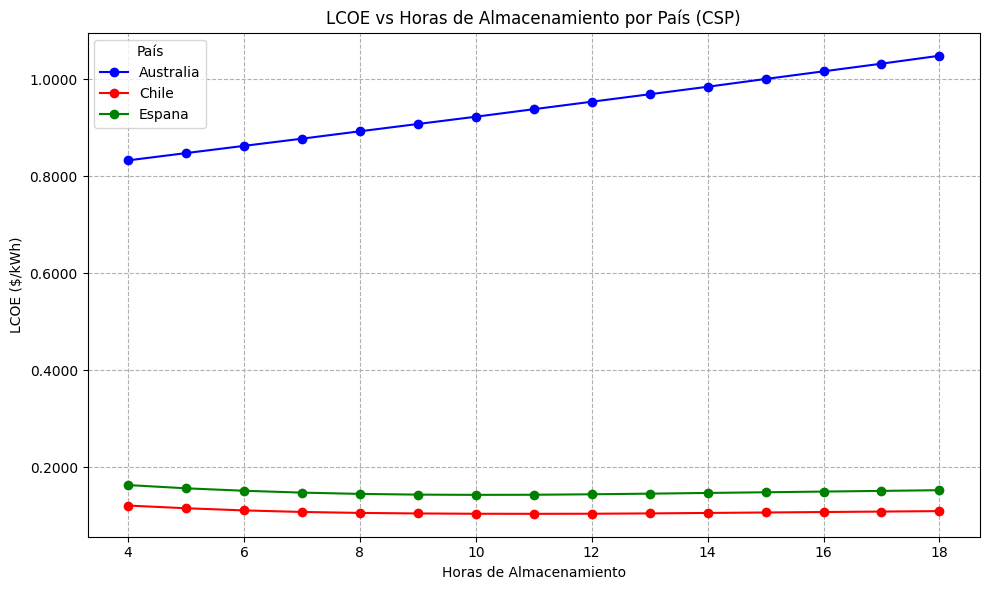

Gráfico lcoe_vs_horas guardado en /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_lcoe_vs_horas_csp.png
--------------------------------------------------


In [16]:
# Generar gráfico LCOE vs Horas
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm, 'lcoe_vs_horas')


### Interpretación del gráfico: LCOE vs Horas de Almacenamiento

El gráfico muestra cómo varía el **Costo Nivelado de Energía (LCOE)** de plantas CSP en función de las horas de almacenamiento térmico, para tres ubicaciones: Chile, España y Australia.

**Observaciones clave:**

- En **Chile** y **España**, el LCOE disminuye levemente hasta un mínimo (alrededor de 10-12 horas de almacenamiento), lo que indica una mejora en la utilización del sistema sin un aumento proporcional en los costos de inversión.
- En **Australia**, el LCOE aumenta continuamente con más horas de almacenamiento, lo que sugiere una menor eficiencia en la conversión o menores niveles de DNI en comparación con los otros países.
- El valor absoluto del LCOE en Chile es el más bajo en todo el rango, indicando una excelente competitividad de la tecnología CSP en ese país.

**Conclusión:**  
Agregar almacenamiento térmico hasta cierto punto (≈10-12 horas) puede reducir el LCOE en sitios con alta irradiancia como Chile y España, pero no necesariamente en ubicaciones con menor recurso solar. Esto destaca la importancia del análisis local en la planificación de proyectos CSP.


--------------------------------------------------
--- Generando Gráfico Específico: energia_vs_horas --- 
--------------------------------------------------


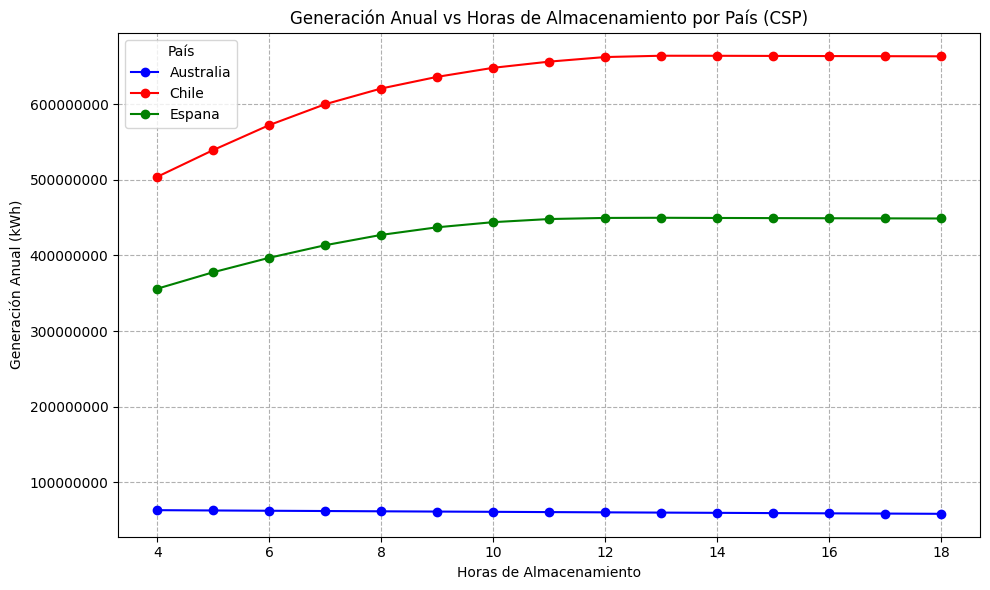

Gráfico energia_vs_horas guardado en /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_energia_vs_horas_csp.png
--------------------------------------------------


In [17]:
# Generar gráfico Energía vs Horas
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm, 'energia_vs_horas')


--------------------------------------------------
--- Generando Gráfico Específico: costo_vs_horas --- 
--------------------------------------------------


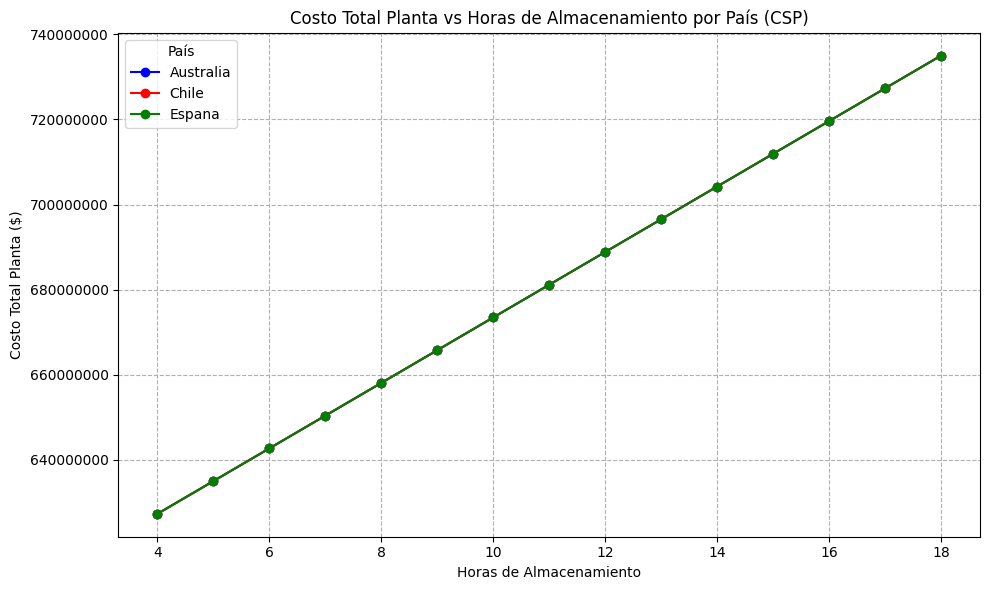

Gráfico costo_vs_horas guardado en /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_costo_vs_horas_csp.png
--------------------------------------------------


In [21]:
# Generar gráfico Costo vs Horas
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm, 'costo_vs_horas')


--------------------------------------------------
--- Generando Gráfico Específico: sens_lcoe_fcr --- 
--------------------------------------------------


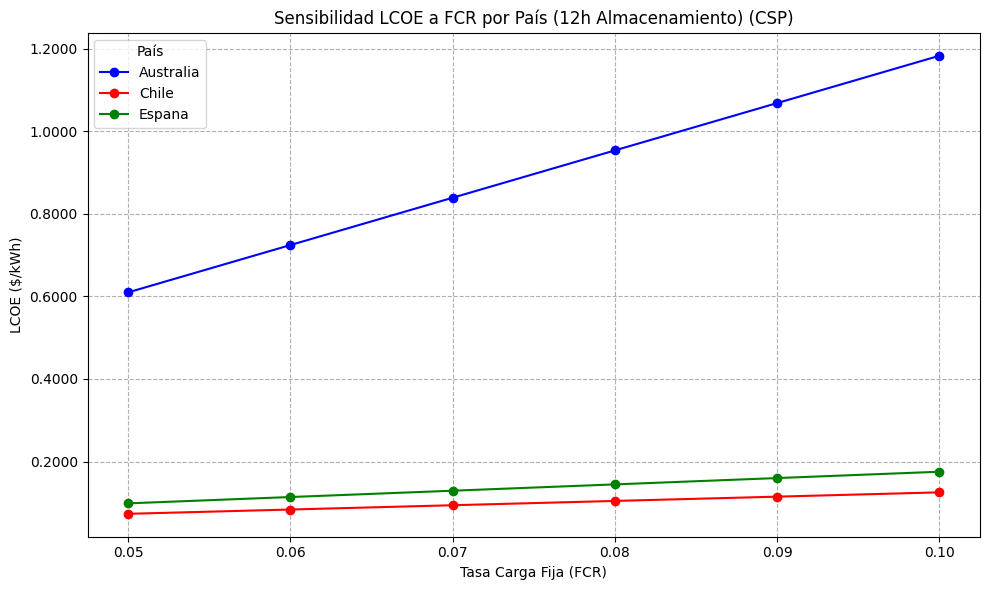

Gráfico sens_lcoe_fcr guardado en /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_sensibilidad_lcoe_vs_fcr_csp.png
--------------------------------------------------


In [22]:
# Generar gráfico Sensibilidad LCOE vs FCR
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm, 'sens_lcoe_fcr')

# Generar gráfico Sensibilidad LCOE vs Múltiplo Solar

--------------------------------------------------
--- Generando Gráfico Específico: sens_lcoe_solarm --- 
--------------------------------------------------


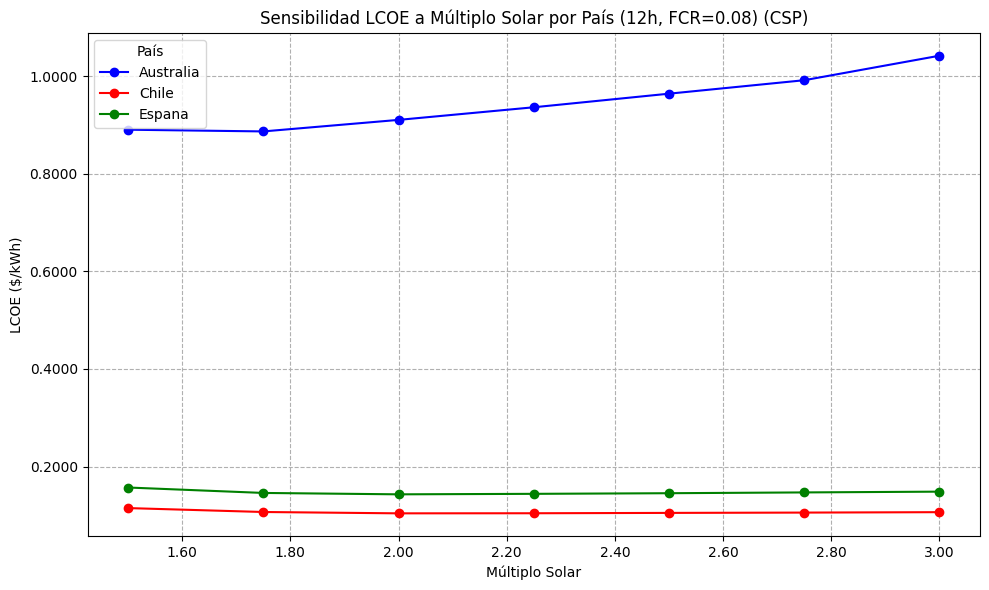

Gráfico sens_lcoe_solarm guardado en /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_sensibilidad_lcoe_vs_solarm_csp.png
--------------------------------------------------


In [23]:
#  Generar gráfico comparativo de LCOE vs Múltiplo Solar
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm, 'sens_lcoe_solarm')

In [6]:
import PySAM.TcsmoltenSalt as TCSMS

# Crea el modelo con valores base desde archivo JSON de ejemplo
modelo = TCSMS.default("MSPTSingleOwner")  # usa el preset térmico base sin layout financiero

# Ahora sí puedes ver los parámetros disponibles
print(modelo.SystemCosts.export())

{'bop_spec_cost': 290.0, 'contingency_rate': 7.0, 'cost_sf_fixed': 0.0, 'csp_pt_cost_epc_fixed': 0.0, 'csp_pt_cost_epc_per_acre': 0.0, 'csp_pt_cost_epc_per_watt': 0.0, 'csp_pt_cost_epc_percent': 13.0, 'csp_pt_cost_plm_fixed': 0.0, 'csp_pt_cost_plm_per_watt': 0.0, 'csp_pt_cost_plm_percent': 0.0, 'fossil_spec_cost': 0.0, 'heliostat_spec_cost': 140.0, 'land_spec_cost': 10000.0, 'plant_spec_cost': 1040.0, 'rec_cost_exp': 0.7, 'rec_ref_area': 1571.0, 'rec_ref_cost': 103000000.0, 'sales_tax_frac': 80.0, 'site_spec_cost': 16.0, 'tes_spec_cost': 22.0, 'tower_exp': 0.0113, 'tower_fixed_cost': 3000000.0}
